In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Neural Network With NAICS Embedding Layer + NAICS hieararchy
Add NAICS embedding to model.  Add additional levels to the hieararchy.   Do not do any data manipulation, so unseen codes get mapped to an input that is not in training

Use the dataset with no missing values. 

Because NAICS_5 is similar to the (6 digit) base NAICS, don't use that one.  Use the other levels

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, \
    Concatenate, Reshape, concatenate, Flatten
import tensorflow.keras.metrics as km

In [6]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model 

## Input Data

In [7]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [8]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [9]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)
naics_max_levels

{'NAICS': 1170,
 'NAICS_5': 764,
 'NAICS_4': 345,
 'NAICS_3': 107,
 'NAICS_sector': 21}

##### Features

In [10]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [11]:
# NAICS feature - all levels except NAICS_5
features_naics = ['NAICS', 'NAICS_4', 'NAICS_3', 'NAICS_sector']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [12]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170, 345, 107, 21]
[8, 4, 4, 2]


##### Datasets for train, validation

In [13]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric].set_index('LoanNr_ChkDgt').sort_index()

In [14]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 10), y:(446848,)


In [15]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 10), y:(95604,)


In [16]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


In [17]:
X_naics = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in features_naics]

In [18]:
X_naics_train = [Xn[Xn['dset'] == 'train'].drop(columns='dset') for Xn in X_naics]
X_naics_val =  [Xn[Xn['dset'] == 'val'].drop(columns='dset') for Xn in X_naics]

## Create, fit model

In [19]:
this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)

2024-05-19 13:22:51.440597: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-19 13:22:51.440628: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-19 13:22:51.440634: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-19 13:22:51.440670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-19 13:22:51.440686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_01 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_02 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                            

In [21]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [22]:
this_history = this_model.fit([X_train] + X_naics_train, y_train,
                              validation_data=([X_val] + X_naics_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs,
                              callbacks=[callback])

Epoch 1/20


2024-05-19 13:22:52.376211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13963/13964 [============================>.] - ETA: 0s - loss: 0.4624 - auc: 0.3365 - auc_1: 0.7003

2024-05-19 13:26:42.956213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - 257s 18ms/step - loss: 0.4624 - auc: 0.3365 - auc_1: 0.7003 - val_loss: 0.4553 - val_auc: 0.3728 - val_auc_1: 0.7226
Epoch 2/20
13964/13964 [==============================] - 293s 21ms/step - loss: 0.4543 - auc: 0.3598 - auc_1: 0.7171 - val_loss: 0.4516 - val_auc: 0.3793 - val_auc_1: 0.7283
Epoch 3/20
13964/13964 [==============================] - 295s 21ms/step - loss: 0.4521 - auc: 0.3672 - auc_1: 0.7217 - val_loss: 0.4519 - val_auc: 0.3814 - val_auc_1: 0.7283
Epoch 4/20
13964/13964 [==============================] - 295s 21ms/step - loss: 0.4508 - auc: 0.3705 - auc_1: 0.7243 - val_loss: 0.4511 - val_auc: 0.3833 - val_auc_1: 0.7290
Epoch 5/20
13964/13964 [==============================] - 304s 22ms/step - loss: 0.4500 - auc: 0.3729 - auc_1: 0.7260 - val_loss: 0.4501 - val_auc: 0.3870 - val_auc_1: 0.7312
Epoch 6/20
13964/13964 [==============================] - 296s 21ms/step - loss: 0.4494 - auc: 0.3753 - auc_1: 0.7271 - val_loss: 0.4496

In [23]:
this_history_df = sbnn_model.process_history(this_history)

In [24]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('04_REPORT_fit_history.csv'))

<Axes: >

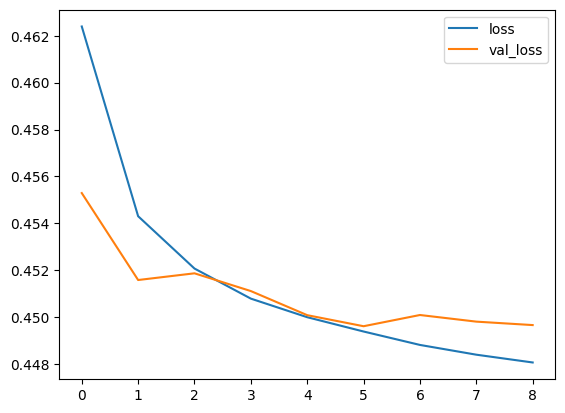

In [25]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

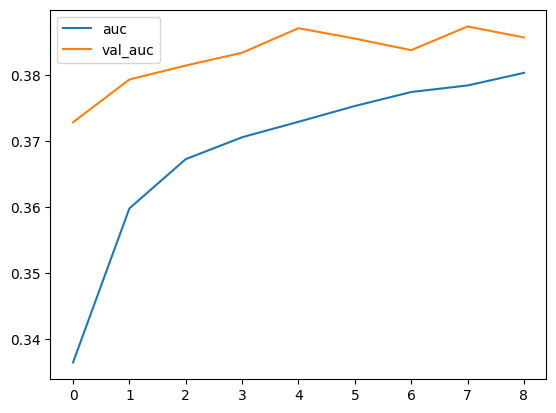

In [26]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

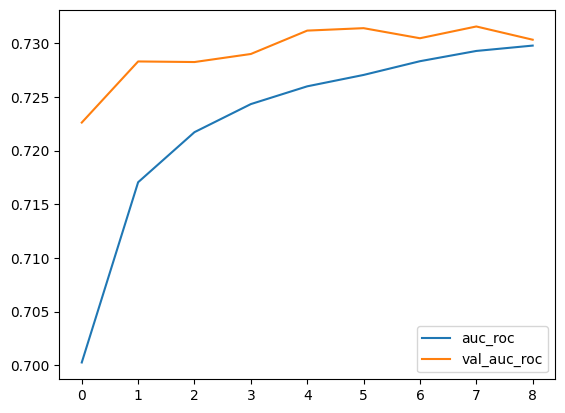

In [27]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [28]:
this_model.save(Path(setup.temp_path).joinpath('04_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [29]:
X_naics = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in features_naics]

In [30]:
all_predictions = this_model.predict([X.drop(columns='dset')] +
                                     [Xn.drop(columns='dset') for Xn in X_naics])

   69/21735 [..............................] - ETA: 48s

2024-05-19 14:05:32.170890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21735/21735 [==============================] - 46s 2ms/step


In [31]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [32]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.322595
target,0.322595,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [33]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [34]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [35]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
12,0.24,0.454390
11,0.22,0.453325
13,0.26,0.451604


In [36]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.24

##### Append binary predictions to probability predictions

In [37]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [38]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.581084
1    0.418916
Name: proportion, dtype: float64

In [39]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('04_DATA_predictions.parquet'))

## Metrics

In [40]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('04_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.620727,0.439317,0.312991,0.736622,0.368105,0.720241,NaN
1,train,0.669597,0.454390,0.341173,0.680066,0.393752,0.736990,NaN
2,val,0.666960,0.450940,0.339584,0.670960,0.385724,0.730382,NaN
0,test,0.663918,0.446207,0.335390,0.666392,0.380095,0.726571,0.0
1,test,0.548938,0.430542,0.287638,0.855634,0.363896,0.727930,1.0
